In [1]:
%cd /mnt/c/Users/Habush/PycharmProjects/bnn_bg
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from utils.train_utils import *
from utils.losses import *
from utils.data_utils import *
from core.sgmcmc import *
from core.bnn_model import *
plt.style.use("ggplot")
%load_ext autoreload

/mnt/c/Users/Habush/PycharmProjects/bnn_bg


2024-01-26 12:52:18.206859: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Mixed BNN

In [2]:
from scipy.stats import binom
def resample_params(key, params, std=0.005):
    num_leaves = len(jax.tree_util.tree_leaves(params))
    normal_keys = list(jax.random.split(key, num_leaves))
    treedef = jax.tree_util.tree_structure(params)
    normal_keys = jax.tree_util.tree_unflatten(treedef, normal_keys)
    params = jax.tree_util.tree_map(lambda p, k: jax.random.normal(k, p.shape) * std,
                               params, normal_keys)
    return params

def get_prior_q(n, p):
    K = max(10,np.log(n))
    q_seq = np.arange(1/p,(1-1/p),1/p)
    probs = abs(binom.cdf(k=K,n=p,p=q_seq)-0.9)
    q = min(q_seq[probs == np.min(probs)])
    return q

In [4]:
%autoreload
from s3.helper_functions import synthetic_data, spike_slab_params
from sklearn.model_selection import train_test_split
n = 500

p = 1000
s0 = 10
seed = 5
synth_data = synthetic_data(seed, n, p, s0, random_index=False)

params = spike_slab_params(n, p, type="linear")
tau0, tau1 = params["tau0"], params["tau1"]
# tau0, tau1 = 1e-2, 1.0
a0, b0 = params["a0"], params["b0"]
q = params["q"]
print(f"params: {params}")
J = jnp.zeros((p, p))
eta, mu = 1.0, 1.0

x, y, true_beta, true_beta_idx = synth_data["X"], synth_data["y"], synth_data["true_beta"], synth_data["true_beta_idx"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

train_set = (x_train, y_train)
test_set = (x_test, y_test)
print(f"true beta idx: {true_beta_idx}")

params: {'q': 0.007, 'tau0': 0.044721359549995794, 'tau1': 1.0, 'a0': 1.0, 'b0': 1.0}
true beta idx: [0 1 2 3 4 5 6 7 8 9]


In [5]:
%autoreload
import core.models as models
import core.sgmcmc_ext as sgmcmc
import utils.nn_util as nn_util
from utils import train_utils
import utils.losses_ext as losses
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions

temp = 1.0
prior_scale = 1.0

splab_log_prob_fn = losses.make_base_dist_log_prob("laplace", 0, tau1**2)
spike_log_prob_fn = losses.make_base_dist_log_prob("laplace", 0, tau0**2)

log_prior_fn = losses.make_spike_slap_log_prior(splab_log_prob_fn, spike_log_prob_fn, temp)
log_likelihood_fn = losses.make_gaussian_likelihood(temp)

bin_log_prior_fn = losses.make_bin_log_prior(J, eta, mu)
q_first, q_last = q, 0.5
bin_log_likelihood_fn = losses.make_bin_log_likelihood(splab_log_prob_fn, spike_log_prob_fn, (q_first, q_last),
                                                       temp)

predict_fn = train_utils.get_regression_gaussian_predictions

lr = 1e-3
bin_lr = 1e-3
mom = 0.95
num_iters = 2000
burnin_len = 1000
cycle_len = 1000
rmsprop_precond = get_rmsprop_preconditioner()
rmsprop_precond_bin = get_rmsprop_preconditioner()
lr_schedule = nn_util.make_constant_lr_schedule_with_cosine_burnin(lr, 1e-8, burnin_len)
bin_lr_schedule = nn_util.make_constant_lr_schedule_with_cosine_burnin(bin_lr, 1e-6, burnin_len)
optimizer = sgmcmc.sgld_gradient_update(lr_schedule, momentum_decay=mom, seed=seed, preconditioner=rmsprop_precond)
bin_optimizer = sgmcmc.disc_bin_sgld_gradient_update(bin_lr_schedule, 
                                                     seed, preconditioner=rmsprop_precond)

init_rng = jax.random.PRNGKey(0)
net_fn = models.make_bnn_model(layer_dims=[100, 100], invsp_noise_std=0.001, 
                               dropout_layer=True)
net = hk.transform_with_state(net_fn)
net_apply, net_init = net.apply, net.init
params, net_state = net.init(init_rng, (x_train[0], None), True)
params = resample_params(init_rng, params, std=0.05)

def init_gamma(key, tree, q):
    num_leaves = len(jax.tree_util.tree_leaves(tree))
    keys = list(jax.random.split(key, num_leaves))
    treedef = jax.tree_util.tree_structure(tree)
    keys = jax.tree_util.tree_unflatten(treedef, keys)
    return jax.tree_map(lambda k, x: tfd.Bernoulli(probs=jnp.ones_like(x)*q).sample(seed=k)*1.0,
                        keys, tree)

first_layer = {k: v for k, v in params.items() if k == "dropout"}
rest_layers = {k: v for k, v in params.items() if k != "dropout"}

first_layer_gamma = init_gamma(init_rng, first_layer, q_first)
rest_layers_gamma = init_gamma(init_rng, rest_layers, q_last)
gamma = {**first_layer_gamma, **rest_layers_gamma}
params["dropout"]["w"] = jnp.zeros_like(gamma["dropout"]["w"])
opt_state = optimizer.init(params)
bin_opt_state = bin_optimizer.init(gamma)
sgmcmc_train_epoch_mixed = train_utils.make_sgd_train_epoch_mixed(
    net_apply, log_likelihood_fn, log_prior_fn, optimizer,
    bin_log_likelihood_fn, bin_log_prior_fn, bin_optimizer, num_batches=5)

In [6]:
all_test_preds = []
key = jax.random.PRNGKey(0)
save_freq = 100

param_samples = []
gamma_samples = []
log_prob_avgs = []
bin_log_probs_avgs = []


# iters = range(num_iters)
iters = tqdm(range(num_iters))

for iteration in iters:
    params, gamma, net_state, opt_state, bin_opt_state, logprob_avg, bin_loss_avg, key = sgmcmc_train_epoch_mixed(
        params, gamma, net_state, opt_state, bin_opt_state, 
        train_set, key)
    # if iteration % save_freq == 0:
    #     _, test_predictions = predict_fn(net_apply, params, net_state, test_set)
    #     all_test_preds.append(np.asarray(test_predictions))
    log_prob_avgs.append(logprob_avg)
    bin_log_probs_avgs.append(bin_loss_avg)
    if iteration > burnin_len and iteration % save_freq == 0:
        param_samples.append(params)
        gamma_samples.append(gamma)
        _, test_predictions = predict_fn(net_apply, params, net_state, test_set)
        all_test_preds.append(onp.asarray(test_predictions))

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:16<00:00, 120.90it/s]


Text(0.5, 1.0, 'Binary variable')

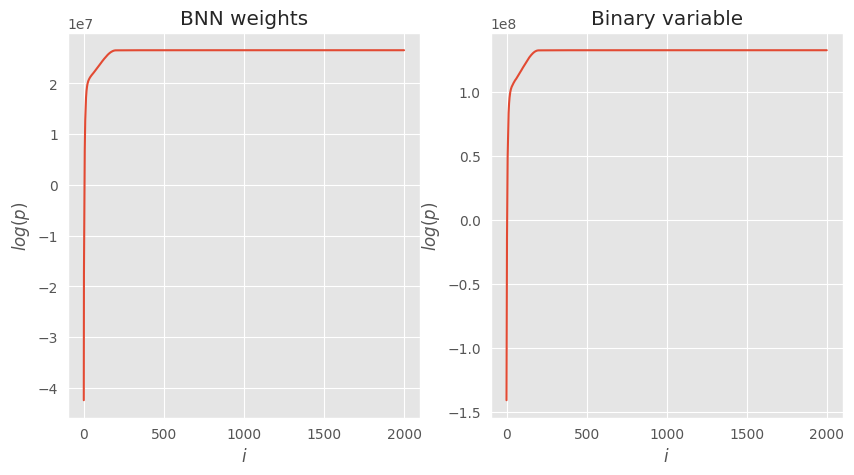

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(log_prob_avgs)
ax1.set_ylabel("$log(p)$")
ax1.set_xlabel("$i$")
ax1.set_title("BNN weights")
ax2.plot(bin_log_probs_avgs)
ax2.set_ylabel("$log(p)$")
ax2.set_xlabel("$i$")
ax2.set_title("Binary variable")

Text(0.5, 1.0, 'Binary variable')

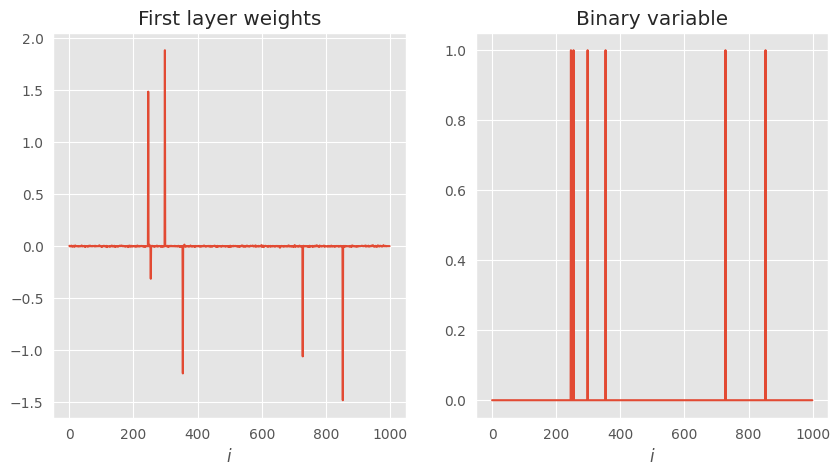

In [8]:
param_samples_st = tree_utils.tree_stack(param_samples)
gamma_samples_st = tree_utils.tree_stack(gamma_samples)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
# ax1.plot(np.mean(np.linalg.norm(param_samples_st["linear_0"]["w"], axis=-1), axis=0))
ax1.plot(np.mean(param_samples_st["dropout"]["w"], axis=0))
ax1.set_xlabel("$i$")
ax1.set_title("First layer weights")
ax2.plot(np.mean(gamma_samples_st["dropout"]["w"], axis=0))
ax2.set_xlabel("$i$")
ax2.set_title("Binary variable")

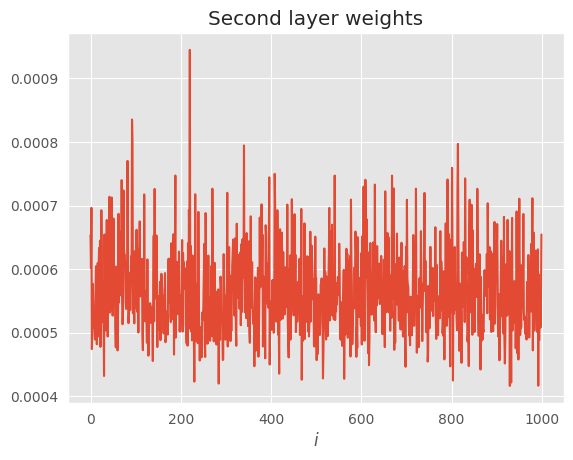

In [9]:
plt.plot(np.mean(np.linalg.norm(param_samples_st["linear_0"]["w"], axis=-1), axis=0))
plt.xlabel("$i$")
plt.title("Second layer weights")
plt.show()

In [10]:
%autoreload
from utils import metrics

data_scale = 1.0
metrics_fns = {
    "scaled_nll": metrics.regression_nll,
    "scaled_mse": metrics.mse,
    "scaled_rmse": metrics.rmse,
    "nll": lambda preds, y: metrics.regression_nll(preds, y, data_scale),
    "mse": lambda preds, y: metrics.mse(preds, y, data_scale),
    "rmse": lambda preds, y: metrics.rmse(preds, y, data_scale),
}

print(f"Number of sampled models: {len(all_test_preds)}")
metrics_val = {"nll": [], "mse": [], "rmse": []}
for pred in all_test_preds[2:]:#[::10][4:]:
    for k in metrics_val:
        metrics_val[k].append(metrics_fns[k](pred, y_test))

for k in metrics_val:
    print(f"{k}: {np.mean(metrics_val[k])}")

Number of sampled models: 9
nll: 51.11760484240431
mse: 48.65782544318171
rmse: 6.975516134955094




### Ribflavin Data

In [459]:
import pandas as pd
seed = 5
data_path = "/mnt/c/Users/Habush/PycharmProjects/bnn_bg/data"
riboflavin = pd.read_csv(f"{data_path}/riboflavin.csv")
riboflavin_y = riboflavin['y'].to_numpy()
riboflavin_x = riboflavin.drop(['y','Unnamed: 0'], axis=1).to_numpy()
print(riboflavin.shape)
riboflavin_x_train, riboflavin_x_test, riboflavin_y_train, riboflavin_y_test = train_test_split(riboflavin_x, 
                                                                                                    riboflavin_y, 
                                                                                                    test_size=0.1, 
                                                                                                    random_state=seed)
n, p = riboflavin_x_train.shape
train_set = (riboflavin_x_train, riboflavin_y_train)
test_set = (riboflavin_x_test, riboflavin_y_test)
print(riboflavin_x_train.shape)

(71, 4090)
(63, 4088)


In [681]:
%autoreload
import core.models as models
import core.sgmcmc_ext as sgmcmc
import utils.nn_util as nn_util
from utils import train_utils
import utils.losses_ext as losses
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions

temp = 1.0
prior_scale = 1.0

params = spike_slab_params(riboflavin_x_train.shape[0], riboflavin_x_train.shape[1],
                            type="linear")
# tau0, tau1 = params["tau0"], params["tau1"]

tau0, tau1 = 1e-3, 0.5
    

slab_log_prob_fn = losses.make_base_dist_log_prob("normal", 0, tau1)
spike_log_prob_fn = losses.make_base_dist_log_prob("normal", 0, tau0)

log_prior_fn = losses.make_spike_slap_log_prior(slab_log_prob_fn, spike_log_prob_fn, temp)
log_likelihood_fn = losses.make_gaussian_likelihood(temp)

bin_log_prior_fn = losses.make_bin_log_prior(J, eta, mu)
q_first, q_last = params["q"], 0.5
bin_log_likelihood_fn = losses.make_bin_log_likelihood(slab_log_prob_fn, spike_log_prob_fn, (q_first, q_last),
                                                       temp)

predict_fn = train_utils.get_regression_gaussian_predictions

net_fn = models.make_bnn_model(layer_dims=[64, 64], invsp_noise_std=0.001, 
                               dropout_layer=True)
net = hk.transform_with_state(net_fn)
net_apply, net_init = net.apply, net.init

lr = 1e-4
bin_lr = 1e-2
mom = 0.95
num_iters = 2000
burnin_len = 1000
cycle_len = 1000
rmsprop_precond = get_rmsprop_preconditioner()
rmsprop_precond_bin = get_rmsprop_preconditioner()
lr_schedule = nn_util.make_constant_lr_schedule_with_cosine_burnin(lr, 1e-6, num_iters)
bin_lr_schedule = nn_util.make_constant_lr_schedule_with_cosine_burnin(bin_lr, 1e-6, num_iters)
# lr_schedule = nn_util.make_cyclical_cosine_lr_schedule(lr, num_iters, cycle_len)
# bin_lr_schedule = nn_util.make_cyclical_cosine_lr_schedule(bin_lr, num_iters, cycle_len)
# lr_schedule = optax.constant_schedule(lr)
# bin_lr_schedule = optax.constant_schedule(bin_lr)
optimizer = sgmcmc.sgld_gradient_update(lr_schedule, momentum_decay=mom, seed=seed, preconditioner=rmsprop_precond)
bin_optimizer = sgmcmc.disc_bin_sgld_gradient_update(bin_lr_schedule,
                                                     seed, preconditioner=rmsprop_precond)
init_rng = jax.random.PRNGKey(seed)

params, net_state = net.init(init_rng, (riboflavin_x_train[0], None), True)
def init_gamma(key, tree, q):
    num_leaves = len(jax.tree_util.tree_leaves(tree))
    keys = list(jax.random.split(key, num_leaves))
    treedef = jax.tree_util.tree_structure(tree)
    keys = jax.tree_util.tree_unflatten(treedef, keys)
    return jax.tree_map(lambda k, x: tfd.Bernoulli(probs=jnp.ones_like(x)*q).sample(seed=k)*1.0,
                        keys, tree)

first_layer = {k: v for k, v in params.items() if k == "dropout"}
rest_layers = {k: v for k, v in params.items() if k != "dropout"}

first_layer_gamma = init_gamma(init_rng, first_layer, q_first)
rest_layers_gamma = init_gamma(init_rng, rest_layers, q_last)
gamma = {**first_layer_gamma, **rest_layers_gamma}
# params["dropout"]["w"] = jnp.zeros_like(gamma["dropout"]["w"])
# params["dropout"]["w"] = gamma["dropout"]["w"]*params["dropout"]["w"]
opt_state = optimizer.init(params)
bin_opt_state = bin_optimizer.init(gamma)
sgmcmc_train_epoch_mixed = train_utils.make_sgd_train_epoch_mixed(
    net_apply, log_likelihood_fn, log_prior_fn, optimizer,
    bin_log_likelihood_fn, bin_log_prior_fn, bin_optimizer, num_batches=2)

In [682]:
all_test_preds = []
key = jax.random.PRNGKey(0)
save_freq = 100

param_samples = []
gamma_samples = []
log_prob_avgs = []
bin_log_probs_avgs = []


# iters = range(num_iters)
iters = tqdm(range(num_iters))

for iteration in iters:
    params, gamma, net_state, opt_state, bin_opt_state, logprob_avg, bin_loss_avg, key = sgmcmc_train_epoch_mixed(
    params, gamma, net_state, opt_state, bin_opt_state, 
    train_set, key)

    log_prob_avgs.append(logprob_avg)
    bin_log_probs_avgs.append(bin_loss_avg)
    # if iteration > burnin_len and (iteration - burnin_len + 1) % cycle_len == 0:
    if iteration > burnin_len and iteration % save_freq == 0:
        param_samples.append(params)
        gamma_samples.append(gamma)
        _, test_predictions = predict_fn(net_apply, params, net_state, test_set)
        all_test_preds.append(onp.asarray(test_predictions))

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:11<00:00, 167.54it/s]


Text(0.5, 1.0, 'Binary variable')

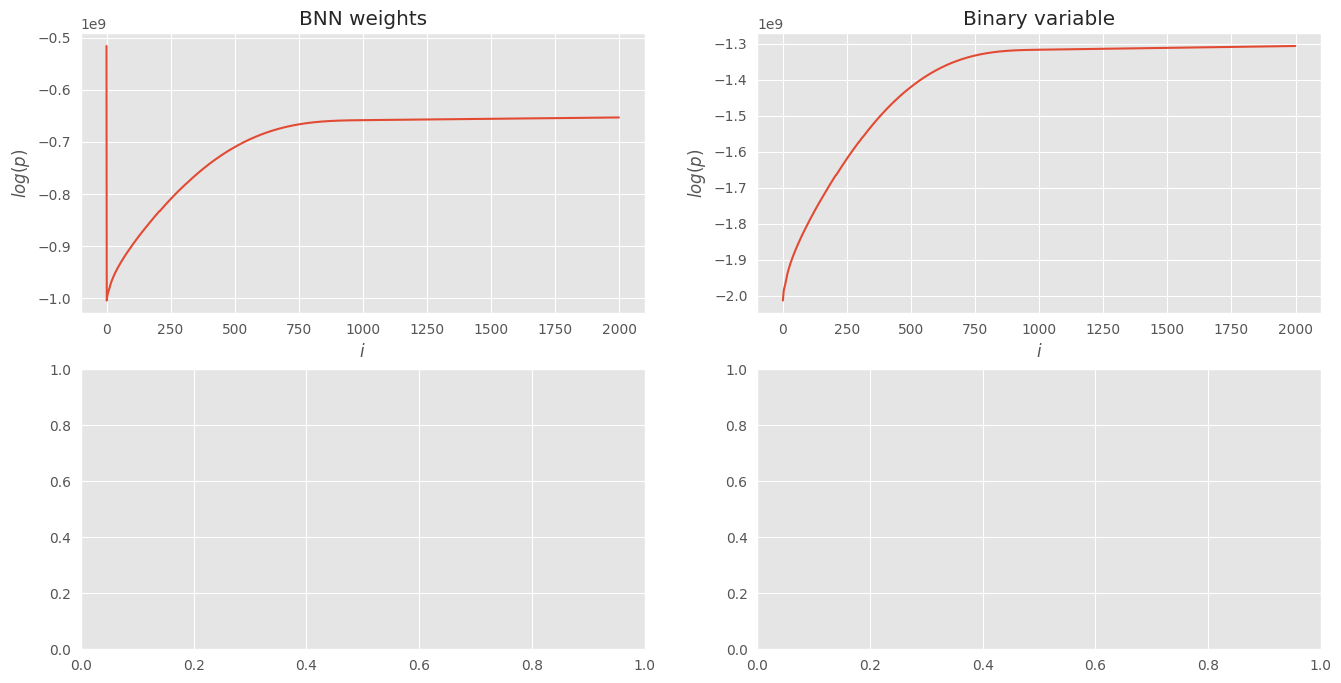

In [683]:
fig, ax = plt.subplots(2, 2, figsize=(16, 8))
ax[0,0].plot(log_prob_avgs)
ax[0,0].set_ylabel("$log(p)$")
ax[0,0].set_xlabel("$i$")
ax[0,0].set_title("BNN weights")
ax[0,1].plot(bin_log_probs_avgs)
ax[0,1].set_ylabel("$log(p)$")
ax[0,1].set_xlabel("$i$")
ax[0,1].set_title("Binary variable")

# param_lrs = [lr_schedule(i) for i in range(num_iters)]
# bin_lrs = [bin_lr_schedule(i) for i in range(num_iters)]
# ax[1,0].plot(param_lrs)
# ax[1,0].axvline(x=burnin_len, color="blue", linestyle="--", label="burnin")
# ax[1,0].set_ylabel("$lr$")
# ax[1,0].set_xlabel("$i$")
# ax[1,0].set_title("Contin LR")
# ax[1,1].plot(bin_lrs)
# ax[1,1].axvline(x=burnin_len, color="blue", linestyle="--", label="burnin")
# ax[1,1].set_ylabel("$lr$")
# ax[1,1].set_xlabel("$i$")
# ax[1,1].set_title("Binary LR")

Text(0.5, 1.0, 'Binary variable')

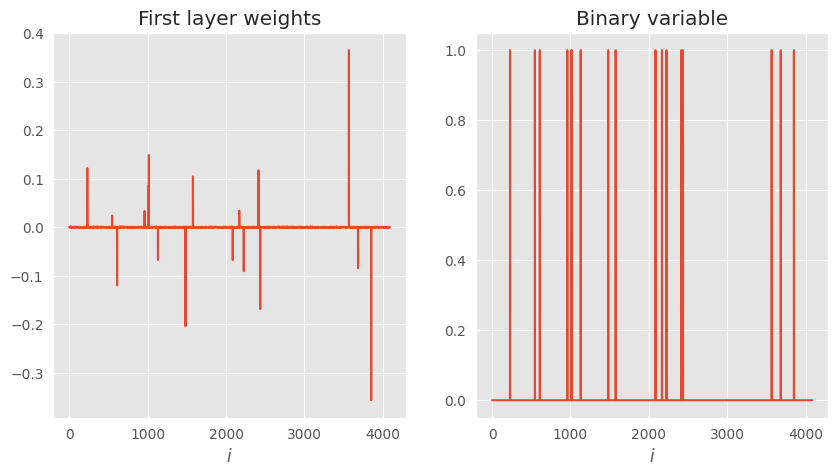

In [684]:
param_samples_st = tree_utils.tree_stack(param_samples)
gamma_samples_st = tree_utils.tree_stack(gamma_samples)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(np.mean(param_samples_st["dropout"]["w"], axis=0))
ax1.set_xlabel("$i$")
ax1.set_title("First layer weights")
# ax2.plot(np.mean(gamma_samples, axis=0))
ax2.plot(np.mean(gamma_samples_st["dropout"]["w"], axis=0))
ax2.set_xlabel("$i$")
ax2.set_title("Binary variable")

In [689]:
np.abs(param_samples_st["dropout"]["w"]).shape

(9, 4088)

In [481]:
%autoreload
from utils import metrics
from scipy import stats
data_scale = 1.0

def calculate_metrics(test_preds, y_test):
    metrics_fns = {
    "mse": lambda preds, y: metrics.mse(preds, y, data_scale),
    "rmse": lambda preds, y: metrics.rmse(preds, y, data_scale),
    "pearson_corr": lambda preds, y: stats.pearsonr(preds[:,0], y)[0],
    "pearson_pval": lambda preds, y: stats.pearsonr(preds[:,0], y)[1],
    }
    metrics_val = {"mse": [], "rmse": [], "pearson_corr": [], "pearson_pval": []}
    for pred in test_preds:
        for k in metrics_val:
            metrics_val[k].append(metrics_fns[k](pred, y_test))
    
    res = {}
    for k in metrics_val:
        res[k] = np.mean(metrics_val[k])
    return res

print(f"Number of sampled models: {len(all_test_preds)}")
res = calculate_metrics(all_test_preds, riboflavin_y_test)
for k in res:
    print(f"{k}: {res[k]}")

Number of sampled models: 9
mse: 0.46934969861601705
rmse: 0.6828901954545905
pearson_corr: 0.46754152305098373
pearson_pval: 0.2634205961112948


In [471]:
import xgboost as xgb

def calculate_xgb_metric(preds, y_test):
    metrics_fns = {
        "mse": lambda preds, y: np.mean((preds - y)**2),
        "rmse": lambda preds, y: np.sqrt(np.mean((preds - y)**2)),
        "pearson_corr": lambda preds, y: stats.pearsonr(preds, y)[0],
        "pearson_pval": lambda preds, y: stats.pearsonr(preds, y)[1],
    }
    metrics_val = {"mse": 0., "rmse": 0., "pearson_corr": 0., "pearson_pval": 0.}
    for k in metrics_val:
        metrics_val[k] = metrics_fns[k](preds, y_test)
    return metrics_val

xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=seed)
xgb_model.fit(riboflavin_x_train, riboflavin_y_train)
xgb_preds = xgb_model.predict(riboflavin_x_test)
xgb_res = calculate_xgb_metric(xgb_preds, riboflavin_y_test)
for k in xgb_res:
    print(f"XGB {k}: {xgb_res[k]}")

XGB mse: 0.5550150986629707
XGB rmse: 0.744993354777726
XGB pearson_corr: 0.7018804756125314
XGB pearson_pval: 0.05231139569897775


In [168]:
xgb_preds

array([-7.0431604, -6.5592866, -7.466504 , -7.0667324, -7.02062  ,
       -6.857985 , -7.720302 , -6.418014 ], dtype=float32)

#### Riboflavin Data - comparison with XGBoost

In [707]:
data_path = "/mnt/c/Users/Habush/PycharmProjects/bnn_bg/data"
riboflavin = pd.read_csv(f"{data_path}/riboflavin.csv")
riboflavin_y = riboflavin['y'].to_numpy()
riboflavin_x = riboflavin.drop(['y','Unnamed: 0'], axis=1).to_numpy()
print(riboflavin_x.shape)

(71, 4088)


In [737]:
%autoreload
import optax
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
import core.sgmcmc_ext as sgmcmc
import utils.nn_util as nn_util
from utils import train_utils
import utils.losses_ext as losses

params = spike_slab_params(riboflavin_x_train.shape[0], riboflavin_x_train.shape[1],
                            type="linear")
# tau0, tau1 = params["tau0"], params["tau1"]

tau0, tau1 = 1e-3, 0.5
    

slab_log_prob_fn = losses.make_base_dist_log_prob("laplace", 0, tau1)
spike_log_prob_fn = losses.make_base_dist_log_prob("laplace", 0, tau0)

log_prior_fn = losses.make_spike_slap_log_prior(slab_log_prob_fn, spike_log_prob_fn, temp)
log_likelihood_fn = losses.make_gaussian_likelihood(temp)

p = riboflavin_x.shape[1]
J = jnp.zeros((p, p))
eta, mu = 1.0, 1.0
bin_log_prior_fn = losses.make_bin_log_prior(J, eta, mu)
q_first, q_last = get_prior_q(riboflavin_x.shape[0], riboflavin_x.shape[1]), 0.5
bin_log_likelihood_fn = losses.make_bin_log_likelihood(slab_log_prob_fn, spike_log_prob_fn, (q_first, q_last),
                                                       temp)

predict_fn = train_utils.get_regression_gaussian_predictions

net_fn = models.make_bnn_model(layer_dims=[64, 64], invsp_noise_std=1e-3, 
                               dropout_layer=True)
net = hk.transform_with_state(net_fn)
net_apply, net_init = net.apply, net.init

lr = 1e-4
bin_lr = 1e-2
mom = 0.95
num_iters = 5000
burnin_len = 3000
cycle_len = 1000
rmsprop_precond = get_rmsprop_preconditioner()
rmsprop_precond_bin = get_rmsprop_preconditioner()
lr_schedule = nn_util.make_constant_lr_schedule_with_cosine_burnin(lr, 1e-6, num_iters)
bin_lr_schedule = nn_util.make_constant_lr_schedule_with_cosine_burnin(bin_lr, 1e-6, num_iters)
# lr_schedule = nn_util.make_cyclical_cosine_lr_schedule(lr, num_iters, cycle_len)
# bin_lr_schedule = nn_util.make_cyclical_cosine_lr_schedule(bin_lr, num_iters, cycle_len)
# lr_schedule = optax.constant_schedule(lr)
# bin_lr_schedule = optax.constant_schedule(bin_lr)

In [738]:

seeds = [477, 5, 10, 43, 234]
all_test_preds = []

def init_gamma(key, tree, q):
    num_leaves = len(jax.tree_util.tree_leaves(tree))
    keys = list(jax.random.split(key, num_leaves))
    treedef = jax.tree_util.tree_structure(tree)
    keys = jax.tree_util.tree_unflatten(treedef, keys)
    return jax.tree_map(lambda k, x: tfd.Bernoulli(probs=jnp.ones_like(x)*q).sample(seed=k)*1.0,keys, tree)

per_seed_metrics = {"bnn" : {"mse": [], "rmse": [], "pearson_corr": [], "pearson_pval": []},
                    "xgb" : {"mse": [], "rmse": [], "pearson_corr": [], "pearson_pval": []}}

per_seed_top_feats = {"bnn" : [], "xgb" : []}
per_seed_feat_importances = {"bnn" : [], "xgb" : []}
k = 100

for seed in tqdm(seeds):
    riboflavin_x_train, riboflavin_x_test, riboflavin_y_train, riboflavin_y_test = train_test_split(riboflavin_x, 
                                                                                                    riboflavin_y, 
                                                                                                    test_size=0.1, 
                                                                                                    random_state=seed)
    n, p = riboflavin_x_train.shape
    train_set = (riboflavin_x_train, riboflavin_y_train)
    test_set = (riboflavin_x_test, riboflavin_y_test)
    
    optimizer = sgmcmc.sgld_gradient_update(lr_schedule, momentum_decay=mom, seed=seed, preconditioner=rmsprop_precond)
    bin_optimizer = sgmcmc.disc_bin_sgld_gradient_update(bin_lr_schedule,
                                                     seed, preconditioner=rmsprop_precond)
    
    init_rng = jax.random.PRNGKey(seed)

    params, net_state = net.init(init_rng, (riboflavin_x_train[0], None), True)

    first_layer = {k: v for k, v in params.items() if k == "dropout"}
    rest_layers = {k: v for k, v in params.items() if k != "dropout"}

    first_layer_gamma = init_gamma(init_rng, first_layer, q_first)
    rest_layers_gamma = init_gamma(init_rng, rest_layers, q_last)
    gamma = {**first_layer_gamma, **rest_layers_gamma}
    params = resample_params(init_rng, params, std=0.05)
    # params["dropout"]["w"] = jnp.zeros_like(gamma["dropout"]["w"])

    opt_state = optimizer.init(params)
    bin_opt_state = bin_optimizer.init(gamma)
    sgmcmc_train_epoch_mixed = train_utils.make_sgd_train_epoch_mixed(net_apply, log_likelihood_fn,
            log_prior_fn, optimizer,bin_log_likelihood_fn, bin_log_prior_fn, bin_optimizer, num_batches=2)
    #%%
    key = jax.random.PRNGKey(seed)
    save_freq = 100

    param_samples = []
    gamma_samples = []
    all_test_preds = []
    # iters = tqdm(range(num_iters))

    for iteration in range(num_iters):
        params, gamma, net_state, opt_state, bin_opt_state, logprob_avg, bin_loss_avg, key = sgmcmc_train_epoch_mixed(params, gamma, net_state, opt_state, bin_opt_state, train_set, key)
    
        # log_prob_avgs.append(logprob_avg)
        # bin_log_probs_avgs.append(bin_loss_avg)
        # if iteration > burnin_len and (iteration - burnin_len) % cycle_len == 0:
        if iteration > burnin_len and iteration % save_freq == 0:
            param_samples.append(params)
            gamma_samples.append(gamma)
            _, test_predictions = predict_fn(net_apply, params, net_state, test_set)
            all_test_preds.append(onp.asarray(test_predictions))
    
    bnn_metrics = calculate_metrics(all_test_preds, riboflavin_y_test)
    for i in per_seed_metrics["bnn"]:
        per_seed_metrics["bnn"][i].append(bnn_metrics[i])
        
    #Rank the features and take the top k
    param_samples_st = tree_utils.tree_stack(param_samples)
    feat_importances = np.mean(np.abs(param_samples_st["dropout"]["w"]), axis=0)
    per_seed_feat_importances["bnn"].append(feat_importances)
    feat_importances = np.argsort(feat_importances)[::-1]
    per_seed_top_feats["bnn"].append(feat_importances[:k])
        
    xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=seed)
    xgb_model.fit(riboflavin_x_train, riboflavin_y_train)
    xgb_preds = xgb_model.predict(riboflavin_x_test)
    xgb_metric = calculate_xgb_metric(xgb_preds, riboflavin_y_test)
    for i in per_seed_metrics["xgb"]:
        per_seed_metrics["xgb"][i].append(xgb_metric[i])
        
    #Rank the features and take the top k
    xgb_feat_importances = xgb_model.feature_importances_
    per_seed_feat_importances["xgb"].append(xgb_feat_importances)
    xgb_feat_importances = np.argsort(xgb_feat_importances)[::-1]
    per_seed_top_feats["xgb"].append(xgb_feat_importances[:k])
    
    

100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.19s/it]


In [721]:
def percent_overlap(a, b):
    return len(np.intersect1d(a, b))/len(np.union1d(a, b))

In [742]:
import pickle
per_seed_feature_ranking = pickle.load(open("./run1_normal/per_seed_feat_ranking_normal.pkl", "rb"))

In [747]:
per_seed_feature_ranking

{'bnn_ss': [Array([ 355, 2845, 3120, ..., 2658, 3792, 2142], dtype=int32),
  Array([2662, 1998, 2215, ...,  346,  275, 2813], dtype=int32),
  Array([1822, 3900, 2070, ..., 2309,  396, 3315], dtype=int32),
  Array([2804,  590, 1517, ..., 3977, 1745,  631], dtype=int32),
  Array([2941, 1519, 2825, ..., 4060, 4081, 2724], dtype=int32)],
 'bnn_all_ss': [array([0.00079966, 0.00103386, 0.00105603, ..., 0.00090932, 0.00100611,
         0.00095451], dtype=float32),
  array([0.00089961, 0.00078066, 0.00096225, ..., 0.00079337, 0.00089157,
         0.00103596], dtype=float32),
  array([0.00067474, 0.00098403, 0.00092343, ..., 0.00080744, 0.0008311 ,
         0.00090852], dtype=float32),
  array([0.00078063, 0.00093201, 0.0007724 , ..., 0.0008232 , 0.000792  ,
         0.0009511 ], dtype=float32),
  array([0.00093789, 0.00115647, 0.00085634, ..., 0.00091482, 0.00107655,
         0.00087963], dtype=float32)],
 'xgb': [array([1296, 2383, 1435, ..., 2702, 2701, 2043]),
  array([2383, 4002, 3310, ...

In [754]:
#Overlap feature selection overlap between seeds
k = 100
for i in range(len(seeds)):
    for j in range(i+1, len(seeds)):
        print(f"Seed {seeds[i]} vs Seed {seeds[j]}")
        print(f"BNN_SS: {percent_overlap(per_seed_feature_ranking['bnn_ss'][i][:k], per_seed_feature_ranking['bnn_ss'][j][:k])}")
        print(f"BNN_SS_ALL: {percent_overlap(per_seed_feature_ranking['bnn_all_ss'][i][:k], per_seed_feature_ranking['bnn_all_ss'][j][:k])}")
        print(f"XGB: {percent_overlap(per_seed_feature_ranking['xgb'][i][:k], per_seed_feature_ranking['xgb'][j][:k])}")

Seed 477 vs Seed 5
BNN_SS: 0.005025125628140704
BNN_SS_ALL: 0.0
XGB: 0.08108108108108109
Seed 477 vs Seed 10
BNN_SS: 0.015228426395939087
BNN_SS_ALL: 0.0
XGB: 0.0582010582010582
Seed 477 vs Seed 43
BNN_SS: 0.030927835051546393
BNN_SS_ALL: 0.0
XGB: 0.12359550561797752
Seed 477 vs Seed 234
BNN_SS: 0.015228426395939087
BNN_SS_ALL: 0.0
XGB: 0.1111111111111111
Seed 5 vs Seed 10
BNN_SS: 0.0
BNN_SS_ALL: 0.0
XGB: 0.08695652173913043
Seed 5 vs Seed 43
BNN_SS: 0.015228426395939087
BNN_SS_ALL: 0.0
XGB: 0.06951871657754011
Seed 5 vs Seed 234
BNN_SS: 0.010101010101010102
BNN_SS_ALL: 0.0
XGB: 0.06382978723404255
Seed 10 vs Seed 43
BNN_SS: 0.015228426395939087
BNN_SS_ALL: 0.0
XGB: 0.06382978723404255
Seed 10 vs Seed 234
BNN_SS: 0.010101010101010102
BNN_SS_ALL: 0.0
XGB: 0.08695652173913043
Seed 43 vs Seed 234
BNN_SS: 0.015228426395939087
BNN_SS_ALL: 0.0
XGB: 0.09289617486338798
